In [1]:
import os
import sys
import argparse
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import operator


import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.backends.cudnn as cudnn

from pytvision.transforms.aumentation import  ObjectImageMetadataTransform
from pytvision.transforms import transforms as mtrans

sys.path.append('../')
import torch.nn.functional as TF
from torchlib.transforms import functional as F
from torchlib.datasets.factory  import FactoryDataset
from torchlib.datasets.datasets import Dataset
from torchlib.datasets.fersynthetic  import SyntheticFaceDataset

from torchlib.attentionnet import AttentionNeuralNet, AttentionGMMNeuralNet
from aug import get_transforms_aug, get_transforms_det

import matplotlib.pyplot as plt
plt.ion()   # interactive mode


## CONFIGURATE

In [5]:
!ls ../out/attnet

att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_bu3dfedark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_ckdark_dim64_preactresnet18x32_fold0_000
att_attnet_ferattention_attloss_adam_jaffedark_dim64_preactresnet18x32_fold0_000


In [6]:
project          = '../out/attnet'
name             = 'att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000'
pathnamedataset  = '~/.datasets'
pathmodel        = os.path.join( project, name, 'models/chk000110.pth.tar' ) #model_best
pathproject      = os.path.join( project, name )
batch_size       = 1
workers          = 1
cuda             = False
parallel         = False
gpu              = 1
seed             = 1
imsize           = 64

## LOAD MODEL

In [7]:
# load model
print('>> Load model ...')

net = AttentionNeuralNet( 
    patchproject=project, 
    nameproject=name, 
    no_cuda=cuda, 
    parallel=parallel, 
    seed=seed, 
    gpu=gpu 
    )

if net.load( pathmodel ) is not True:
    assert(False)

>> Load model ...
=> loading checkpoint '../out/attnet/att_attnet_ferattention_attloss_adam_affectnetdark_dim64_preactresnet18x32_fold0_000/models/chk000110.pth.tar'
=> loaded checkpoint for ferattention arch!


## DATASETS

In [8]:
print('>> Load dataset ...')
namedataset = FactoryDataset.affect
subset = FactoryDataset.validation
imagesize=128

dataset = Dataset(    
    data=FactoryDataset.factory(
        pathname=pathnamedataset, 
        name=namedataset, 
        subset=subset, 
        download=True 
    ),
    num_channels=3,
    transform=transforms.Compose([
            mtrans.ToResize( (imagesize,imagesize), resize_mode='square' ),
            mtrans.ToTensor(),
            #mtrans.ToMeanNormalization( mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] )
            mtrans.ToNormalization(),
            ])
    )

# emotions = dataset.data.classes
emotions = ['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']

# if namedataset == FactoryDataset.bu3dfe:
#     emotions = emotions[:-1]
print(emotions)
print(len(emotions))


>> Load dataset ...
['Neutral - NE', 'Happiness - HA', 'Surprise - SU', 'Sadness - SA', 'Anger - AN', 'Disgust - DI', 'Fear - FR', 'Contempt - CO']
8


(64, 64, 3)
tensor([0.1100, 0.1494, 0.1127, 0.1105, 0.1179, 0.1093, 0.1808, 0.1094],
       device='cuda:1')
tensor(6, device='cuda:1')
Fear - FR


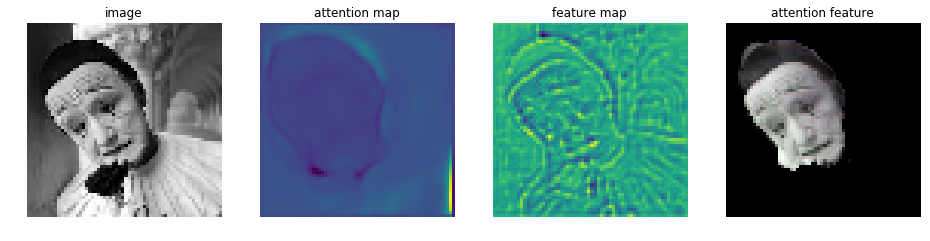

In [24]:
import random

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape
    im_pad = np.zeros( (h+2*xypad,w+2*xypad) )
    im_pad[xypad:xypad+h,xypad:xypad+w] = image
    return im_pad
    
def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop ]
    return image 
    
imagesize=64
image = cv2.imread('../rec/selfie_sadness.png')[:,:,0]
# image = pad(image,50)
# image = crop(image,10)

# sigma=0.1
# image = image/255.0
# noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]  )])
# noise = noise.reshape(image.shape[0],image.shape[1])
# image = (np.clip(image+noise,0,1)*255).astype(np.uint8)

image = np.stack( (image,image,image), axis=2 )
image = cv2.resize( image, (imagesize, imagesize) )

# gamma=0.1
# image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
# image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
# image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255

image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
# image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
image = image/255

y_lab_hat, att, fmap, srf = net( image )


att  = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
image = image.data.cpu().numpy().transpose(2,3,1,0)[...,0]
y_lab_hat_max = y_lab_hat.argmax()


print(image.shape)
print( TF.softmax( y_lab_hat, dim=1 )[0,:]  )
print(y_lab_hat_max)
print(emotions[y_lab_hat_max])

plt.figure( figsize=(16,8))
plt.subplot(141)
plt.imshow( norm(image) )
plt.title('image')   
plt.axis('off')
plt.subplot(142)
plt.imshow( (fmap))
plt.title('attention map') 
plt.axis('off' )
plt.subplot(143)
plt.imshow( srf.sum(2) )
plt.title('feature map') 
plt.axis('off' )
plt.subplot(144)
plt.imshow( norm(att) )  
# plt.title('class {}'.format( y_lab_hat_max ) ) 
plt.title('attention feature') 
plt.axis('off')



plt.show()

In [44]:
import scipy.misc
import random

def sigmoid(x):
    return 1. / (1 + np.exp(-x))

def norm(x):
    x = x-x.min()
    x = x / x.max()
    return x

def mean_normalization(image, mean, std):
    tensor = image.float()/255.0
    result_tensor = []
    for t, m, s in zip(tensor, mean, std):  
        result_tensor.append(t.sub_(m).div_(s))            
    return torch.stack(result_tensor, 0)

def pad(image, xypad):
    h,w = image.shape[:2]
    im_pad = np.zeros( (h+2*xypad,w+2*xypad,3) )
    im_pad[xypad:xypad+h,xypad:xypad+w, :] = image
    return im_pad

def crop(image, xycrop):
    h,w = image.shape[:2]
    image = image[ xycrop:h-xycrop,xycrop:w-xycrop , :]
    return image 


def fusion( imx, imy, x=0,y=0, alpha=0.5 ):
    n,m = imy.shape[:2]
    imx[ x:x+n,y:y+m, : ] = alpha*imx[ x:x+n,y:y+m, : ] + (1-alpha)*imy
    return imx

def noise(image, sigma=0.05):
    image = image/255.0
    noise = np.array([random.gauss(0,sigma) for i in range( image.shape[0]*image.shape[1]*3  )])
    noise = noise.reshape(image.shape[0],image.shape[1],3)
    image = (np.clip(image+noise,0,1)*255).astype(np.uint8)
    return image
    
def ligth(image, gamma=0.2):
    image[:,:,0] = norm((image[:,:,0]/255)**gamma)*255
    image[:,:,1] = norm((image[:,:,1]/255)**gamma)*255
    image[:,:,2] = norm((image[:,:,2]/255)**gamma)*255
    return image

class cTrack(object):
    '''track frame
    '''
    
    def __init__(self, net, image_size=64):
        self.imagesize=image_size
        self.net=net
    
    def __call__(self, frame):
        
        #image = frame
        image = frame.mean(axis=2)        
        image = np.stack( (image,image,image), axis=2 )
        
        image = cv2.resize( image, (self.imagesize, self.imagesize) )
        image = torch.from_numpy(image).permute( (2,0,1) ).unsqueeze(0).float()
        #image = mean_normalization(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        image = image/255
        
        y_lab_hat, att, fmap, srf = self.net( image )
        
        att = att.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        fmap = fmap.data.cpu().numpy().transpose(2,3,1,0)[:,:,0,0]
        srf  = srf.data.cpu().numpy().transpose(2,3,1,0)[...,0]
        y_lab_hat_max = y_lab_hat.argmax()
        
        return att, fmap, srf, y_lab_hat, y_lab_hat_max

    
class cFrame(object):
    '''frames porcess
    '''        
    def __init__(self, image_size=[640, 640, 3], border=0, offsetx=0, offsety=0):     
        self.imagesize  = image_size
        self.asp = float(image_size[1])/image_size[0]
        self.border = border
        self.offsetx = offsetx
        self.offsety = offsety 
       
        
    def __call__(self, frame):
        '''process frame 
        '''        
        #H, W original image size
        H=frame.shape[0]; W=frame.shape[1];
        
        #image canonization
        if H>W: frame = frame.transpose(1,0,2)
        H=frame.shape[0]; W=frame.shape[1]     
        
        H1 = int(H - self.border)
        W1 = int(H1 * self.asp)
        offsetx=self.offsetx
        offsety=self.offsety
        Wdif = int(np.abs(W - W1) / 2.0)
        Hdif = int(np.abs(H - H1) / 2.0)
        vbox = np.array([[Wdif, Hdif], [W - Wdif, H - Hdif]])

        frame_p = frame[vbox[0, 1]+offsety:vbox[1, 1]+offsety, vbox[0, 0]+offsetx:vbox[1, 0]+offsetx, : ]; #(2, 1, 0)
        aspY = float(self.imagesize[0]) / frame_p.shape[0]
        aspX = float(self.imagesize[1]) / frame_p.shape[1]

        frame_p = scipy.misc.imresize(frame_p, (self.imagesize[0], self.imagesize[1]), interp='bilinear')
        
        return frame_p
    
    
def drawcaption( y, emotions, imsizeout=(200,200) ):    
    
    ne = len(emotions)
    colors = ([150,150,150],[125,125,125],[255,255,255],[255,255,255])
    hbox=40; wbox= 135 + 170
    
    imsize=(hbox*ne,wbox,3)
    imemotions = np.zeros( imsize, dtype=np.uint8 )*255    
    
    ymax = y.argmax()
    
    for i, yi in enumerate(y):

        k  = 1 if y[i]>0.5 else 0
        kh = 1 if ymax==i else 0
    
        bbox = np.array([[0,0],[wbox,0],[wbox,hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=colors[kh] )
        
        bbox = np.array([[0,0],[int(wbox*y[i]),0],[int(y[i]*wbox),hbox],[0,hbox]]);    
        bbox[:,0] += 0
        bbox[:,1] += 26-26 + (i)*40
        imemotions = cv2.fillConvexPoly(imemotions, bbox, color=[255,160,122] )
        
        cv2.putText(
                imemotions, 
                #'{}: {:.3f}'.format(emotions[i][:-5],y[i]),
                '{}: {:.2f}%'.format(emotions[i][:-5], y[i]*100 ),
                (2, 26 + (i)*40), 
                color=colors[2+kh], 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=1, 
                thickness=2
                )
        
    #imemotions = imemotions[20:-20,20:-20,:]
    imemotions = cv2.resize( imemotions, imsizeout )
    return imemotions



In [50]:
import cv2 
from IPython.display import clear_output

filename = '../out/videos/happy.avi'  
cap = cv2.VideoCapture( filename )

print(cap.isOpened())
frame_proc = cFrame( image_size=[128,128,3] ) 
track   = cTrack( net, image_size=64 )

k = 0
iframe=0
totalframe=30
iniframe=0 #0, 1700

bligth=False
mingam, maxgam = 0.5, 3.0 
#gammas = mingam + np.random.rand(totalframe)*( maxgam - mingam )
gammas = np.linspace( mingam, maxgam, num=totalframe+1 )
gammas = gammas[::-1]
#gammas.sort()


bnoise=False
minnoise, maxnoise = 0.01, 0.08
# sigmas = minnoise + np.random.rand(totalframe)*( maxnoise - minnoise )
sigmas = np.linspace( minnoise, maxnoise, num=totalframe+1 )
sigmas = sigmas[::-1]
#sigmas.sort()


# for every frame
while(cap.isOpened()):
    
    # read
    #for i in range(100): 
    #    ret, frame = cap.read()

    ret, frame = cap.read()
    if not ret:
        k+=1
        print('Error video')
        break

    if k%1 != 0 or k < iniframe:
        k+=1
        continue
        
    #print(k)   
    #frame = frame[:-300,850:,:]
    #frame = frame[50:-350,500:1350,:]
    
    frame = frame[0:500,0:500,:] # happy, sad1
    #frame = frame[0:700,0:700,:]
    #frame = frame[100:700,100:700,:]
    #frame = frame[0:320,350:720,:] # sad2(crop 30)
    #frame = frame[50:450,300:720,:] #fear
    
    image = frame_proc( frame )
    image = crop(image,30)
    #image = pad(image, 20)
    #image = ligth(image, gamma = 0.3 )
       
    #noise
    if bnoise:
        image = noise(image, sigma=sigmas[iframe - iniframe])  
        image = np.clip(image, 0, 255 )
    
    #ligth
    if bligth:
        image = ligth(image, gamma = gammas[iframe - iniframe] )
        image = np.clip(image, 0, 255 )
    
    att, fmap, srf, yhat, yhat_max = track( image )
    yhat = TF.softmax( yhat, dim=1 )[0,:]
    att_map = att.mean(axis=2)
    
    #print(yhat)
    
    
    #create video frame   
    imsize=500
    midsize=250
    layer   = np.zeros( [768, 2024, 3] , dtype=np.uint8 )*255 #1024    
    caption = drawcaption(yhat, emotions )
    image   = cv2.resize( image, (imsize,imsize) )[:,:,(2,1,0)]
    att     = cv2.resize( norm(att)*255, (imsize,imsize) )
    fmap    = cv2.resize( norm(fmap.sum(axis=2))*255, (imsize,imsize) )
    srf     = cv2.resize( norm(srf.sum(axis=2))*255, (imsize,imsize) )
    
    #att     = cv2.resize( norm(att)*255, (midsize,midsize) )
    #fmap    = cv2.resize( norm(fmap)*255, (midsize,midsize) )
    #srf     = cv2.resize( norm(srf.sum(axis=2))*255, (midsize,midsize) )
    
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    fmap = cv2.applyColorMap( fmap.astype(np.uint8) , cv2.COLORMAP_JET)[:,:,(2,1,0)]
    srf = cv2.applyColorMap( srf.astype(np.uint8), cv2.COLORMAP_JET)[:,:,(2,1,0)]
    
    #att     = np.concatenate( (att, att_t), axis=0 )
    #feature = np.concatenate( (fmap, srf ), axis=0 )
    #feature = np.stack( (feature, feature,feature ), axis=2 )    
    #image   = np.concatenate( (image, feature, att), axis=1 )
    
    image   = np.concatenate( (image, fmap, srf, att), axis=1 )
    
    #layer
    layer = fusion(layer, image, x=10+100, y=10, alpha=0.0 )
    layer = fusion(layer, caption, x=20+100, y=20, alpha=0.2 )
    
    #cv2.imwrite('../out/result/{:06d}.png'.format( iframe + 0*(totalframe + 1) ), layer[:,:,(2,1,0)] )
    k+=1; iframe+=1
    
    # show
    ishow=True
    if ishow:
        plt.figure( figsize=(25,8) )
        plt.imshow( layer )
        plt.axis('off')
        plt.show()
        clear_output(wait=True) 
    
    if iframe%100 == 0:
        print(k, iframe)        
    
    if k > iniframe+totalframe:
        break

    
        
        
cap.release()
# print('DONE!!!')



True


In [108]:
STANDARD_COLORS = [
    'AliceBlue', 'Chartreuse', 'Aqua', 'Aquamarine', 'Azure', 'Beige', 'Bisque',
    'BlanchedAlmond', 'BlueViolet', 'BurlyWood', 'CadetBlue', 'AntiqueWhite',
    'Chocolate', 'Coral', 'CornflowerBlue', 'Cornsilk', 'Crimson', 'Cyan',
    'DarkCyan', 'DarkGoldenRod', 'DarkGrey', 'DarkKhaki', 'DarkOrange',
    'DarkOrchid', 'DarkSalmon', 'DarkSeaGreen', 'DarkTurquoise', 'DarkViolet',
    'DeepPink', 'DeepSkyBlue', 'DodgerBlue', 'FireBrick', 'FloralWhite',
    'ForestGreen', 'Fuchsia', 'Gainsboro', 'GhostWhite', 'Gold', 'GoldenRod',
    'Salmon', 'Tan', 'HoneyDew', 'HotPink', 'IndianRed', 'Ivory', 'Khaki',
    'Lavender', 'LavenderBlush', 'LawnGreen', 'LemonChiffon', 'LightBlue',
    'LightCoral', 'LightCyan', 'LightGoldenRodYellow', 'LightGray', 'LightGrey',
    'LightGreen', 'LightPink', 'LightSalmon', 'LightSeaGreen', 'LightSkyBlue',
    'LightSlateGray', 'LightSlateGrey', 'LightSteelBlue', 'LightYellow', 'Lime',
    'LimeGreen', 'Linen', 'Magenta', 'MediumAquaMarine', 'MediumOrchid',
    'MediumPurple', 'MediumSeaGreen', 'MediumSlateBlue', 'MediumSpringGreen',
    'MediumTurquoise', 'MediumVioletRed', 'MintCream', 'MistyRose', 'Moccasin',
    'NavajoWhite', 'OldLace', 'Olive', 'OliveDrab', 'Orange', 'OrangeRed',
    'Orchid', 'PaleGoldenRod', 'PaleGreen', 'PaleTurquoise', 'PaleVioletRed',
    'PapayaWhip', 'PeachPuff', 'Peru', 'Pink', 'Plum', 'PowderBlue', 'Purple',
    'Red', 'RosyBrown', 'RoyalBlue', 'SaddleBrown', 'Green', 'SandyBrown',
    'SeaGreen', 'SeaShell', 'Sienna', 'Silver', 'SkyBlue', 'SlateBlue',
    'SlateGray', 'SlateGrey', 'Snow', 'SpringGreen', 'SteelBlue', 'GreenYellow',
    'Teal', 'Thistle', 'Tomato', 'Turquoise', 'Violet', 'Wheat', 'White',
    'WhiteSmoke', 'Yellow', 'YellowGreen'
]


def imageshow( image ):
    plt.figure( figsize=(10,10))
    plt.imshow(image)
    plt.axis('off')
    plt.ioff()
    plt.show()


# x,y,w,h -> x1,y1,x2,y2 
def tobbox(box):
    return np.array( [box[0], box[1], box[2]+box[0], box[3]+box[1] ] )

def drawface(image, bbox ):    
    cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2],bbox[3]), color=[10,10,128], thickness=3)
    return image    

def roi( image, box ):
    imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    roi_gray = imgray[box[1]:box[3], box[0]:box[2]]
    return roi_gray


def dictbox2arraybox(box):
    bbox = np.array([box['top'],box['left'],box['top']+box['width'],box['left']+box['height']])
    return bbox


def draw_bounding_box(image, bbox, label, color='red', thickness=4):
    
    image_pil = Image.fromarray(np.uint8(image)).convert('RGB') 
    im_width, im_height = image_pil.size

    draw = ImageDraw.Draw(image_pil)
    #xmin = bbox[0,0]; ymin = bbox[0,1];
    #xmax = bbox[1,0]; ymax = bbox[1,1];
    #(left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    (left, top, right, bottom ) = bbox

    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    
    try:
        font = ImageFont.truetype('/usr/share/fonts/freefont/FreeSans.ttf', 32, encoding="unic") #'arial.ttf'
        #font = ImageFont.truetype('arial.ttf', 32) 
    except IOError:
        font = ImageFont.load_default()
    
    text_bottom = top
    
    # Reverse list and print from bottom to top.
    #for display_str in display_str_list[::-1]:
    
    emtname=label[0]
    emtscore=label[1]
    display_str = '{}:{:.2f}% '.format( emtname, emtscore*100 );
    
    text_width, text_height = font.getsize( display_str )
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
        [(left, text_bottom - text_height - 2 * margin), 
        (left + text_width, text_bottom)],
        fill=color)
    
    draw.text(
        (left + margin, text_bottom - text_height - margin),
        display_str,
        fill='black',
        font=font)
    text_bottom -= text_height - 2 * margin
    
    np.copyto(image, np.array(image_pil))


    
    
def showatt( image, yhat, att, fmap, srf, emotions, imsize=500, midsize=250):
    
    #layer   = np.zeros( [768, 2024, 3] , dtype=np.float ) #1024    
    #caption = drawcaption(yhat, emotions )/255
    
    image   = cv2.resize( image/255, (imsize,imsize) )[:,:,(2,1,0)]
    #att     = cv2.resize( norm(att)*255, (imsize,imsize) )
    att     = cv2.resize( att, (imsize,imsize) )
    fmap    = cv2.resize( norm(fmap)*255, (imsize,imsize) )
    srf     = cv2.resize( norm(srf.sum(axis=2))*255, (imsize,imsize) )    
    
    #https://www.learnopencv.com/applycolormap-for-pseudocoloring-in-opencv-c-python/
    fmap = cv2.applyColorMap( fmap.astype(np.uint8) , cv2.COLORMAP_JET)[:,:,(2,1,0)]/255
    srf = cv2.applyColorMap( srf.astype(np.uint8), cv2.COLORMAP_JET)[:,:,(2,1,0)]/255    
    image   = np.concatenate( (image, fmap, srf, att), axis=1 )
    
    #layer = fusion(layer, image, x=10+100, y=10, alpha=0.0 )
    #layer = fusion(layer, caption, x=20+100, y=20, alpha=0.2 )
    
    return image
    
    

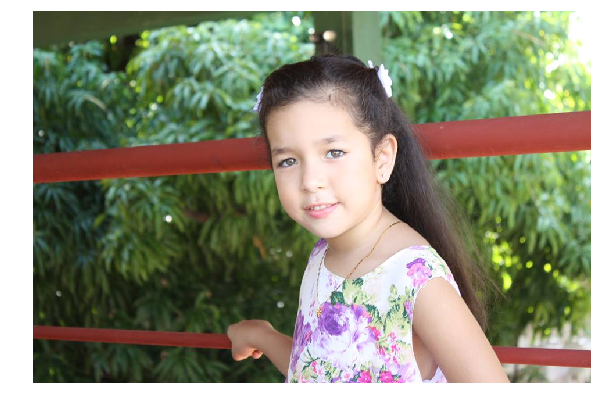

In [65]:
pathnameimage = '../out/image960x640.jpg'
image = cv2.imread(pathnameimage)[:,:,(2,1,0)]
imageshow(image)

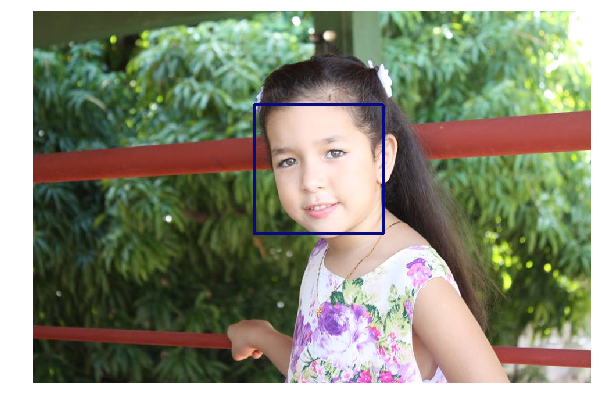

In [4]:
#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

image_sh = image.copy()
for box in faces:
    drawface( image_sh, tobbox(box) )
imageshow( image_sh )


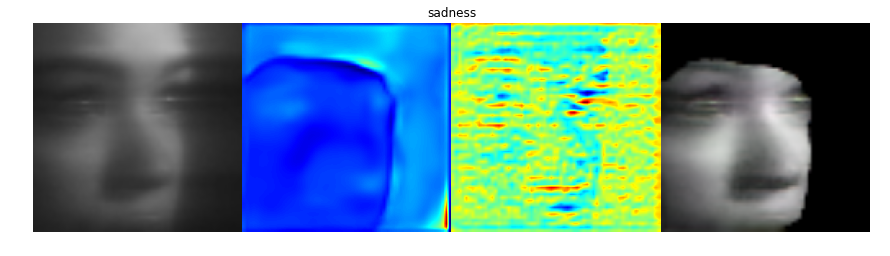

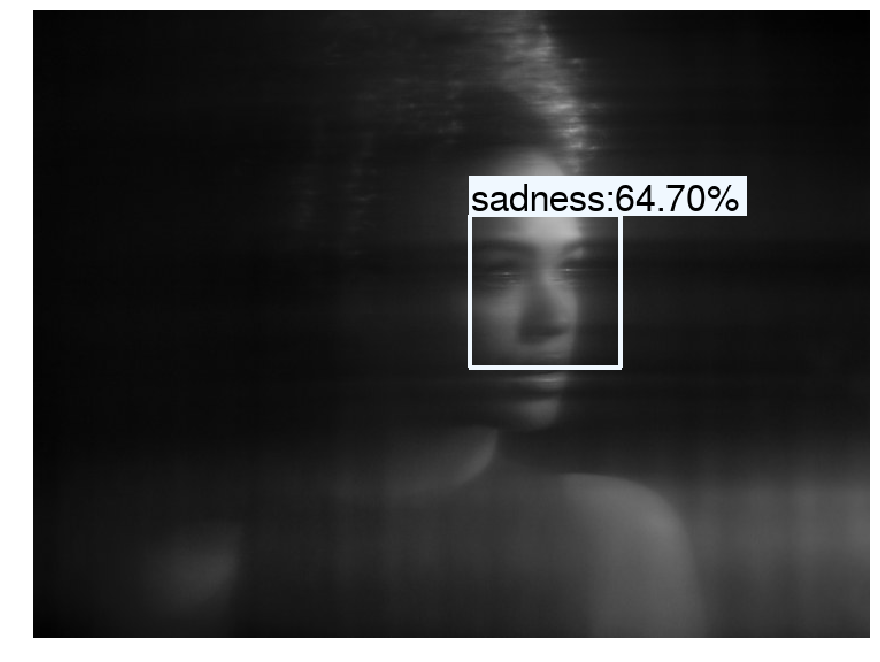

In [120]:
# emotion_name = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

# pathnameimage = '../out/image960x640.jpg'
# pathnameimage = '../out/image1024x760.jpg'
pathnameimage = '../out/tristesa_5.jpg'

image = cv2.imread(pathnameimage)[:,:,(2,1,0)]


#x,y,w,h
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

# face detection
imgray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(imgray, 1.3, 5)

# classification
frame_proc = cFrame( image_size=[128,128,3] ) 
track   = cTrack( net, image_size=64 )

# emotion recognition
image_sh = image.copy()
for k, box in enumerate(faces):
    
    bbox = tobbox(box)
    imface = roi(image, bbox)
    
    
    #imface = tofer(imface)
    #imfacetensor = torch.from_numpy(imface[:,:,np.newaxis, np.newaxis].transpose((2, 3, 0, 1))).float()
    #imfacetensor = torch.cat((imfacetensor, imfacetensor, imfacetensor), dim=1)
    
    imagesize = 64
    imface = np.stack( (imface,imface,imface), axis=2 )
    imface = cv2.resize( imface, (imagesize, imagesize) )

    # predict 
    att, fmap, srf, yhat, yhat_max = track( imface )
    att_map = att.mean(axis=2)
       
    score = dict(zip(emotion_name, yhat[0] ))    
    labelhat = TF.softmax( yhat, dim=1 )[0,:]
    curremot = max(score.items(), key=operator.itemgetter(1)) 
    
#     print('face: ', k)
#     print('----------------------------')
#     for e,v in score.items():
#         print(e, '{:.4f}'.format(v*100) )
    
    # draw result
    draw_bounding_box( image_sh, bbox, curremot, color=STANDARD_COLORS[k] )
    #drawface( image_sh, bbox )
    
    
    im_att = showatt( imface, labelhat, att, fmap, srf, emotion_name, imsize=500, midsize=250 )
    
    
    plt.figure( figsize=(15,8) )
    plt.imshow( im_att )
    plt.title( emotion_name[  torch.argmax(labelhat) ] )
    plt.axis('off')
    plt.ioff()
    plt.show()


plt.figure( figsize=(15,20) )
plt.imshow(image_sh)
plt.axis('off')
plt.ioff()
plt.show()







In [ ]:
class cDetectionNet(object):
    
    def __init__(self, net):
        self.network = net
    
    def create(self):
        self.face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        self.tofer = ferptransform.FERImageDistort( 
            width=self.network.size_input, 
            height=self.network.size_input, 
            determinisitc=True, 
            preproc=True)
        self.totensor = transforms.ToTensor()
        
        
    def process(self, frame):
        
        # predict face
        imgray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        faces = self.face_cascade.detectMultiScale(imgray, 1.3, 5)
        
        # emotion recognition
        image_sh = frame.copy()
        for k, box in enumerate(faces):
            
            bbox = tobbox(box)
            imface = roi(image, bbox)
            imface = self.tofer(imface)
            imfacetensor = torch.from_numpy(imface[:,:,np.newaxis, np.newaxis].transpose((2, 3, 0, 1))).float()
            imfacetensor = torch.cat((imfacetensor, imfacetensor, imfacetensor), dim=1)

            # predict emotion
            y = self.network.inference(imfacetensor)[0]
            score = dict(zip(emotion_name, y))
            labelhat = np.argmax(y)
            curremot = max(score.items(), key=operator.itemgetter(1)) 
            
            print('face: ', k)
            print('----------------------------')
            for e,v in score.items():
                print(e, '{:.4f}'.format(v*100) )

            # draw result
            draw_bounding_box(image_sh, bbox, curremot, color=STANDARD_COLORS[k], thickness=4)
        
        return image_sh

In [ ]:
import pylab
import imageio

#filename = '../../db/video/tmp.mp4'
#cap = cv2.VideoCapture( filename )
#print(cap.isOpened())

#iter = 0;
#for every frame
#while(cap.isOpened()):
#     ret, frame = cap.read();    
#     iter+=1;
#     frame = frame[:,:,(2,1,0)]
#     print(frame.shape)    
#     break;


detector = cDetectionNet(network)
detector.create()

filename = '../../db/video/005138840.avi'
vid = imageio.get_reader(filename,  'ffmpeg')
nums = [1, 2, 3, 4]
for num in nums:
    
    image = vid.get_data(num)
    image = cv2.resize(image, None, fx=0.5, fy=0.5 )
    print(image.shape, image.min(), image.max() )
    
    image = detector.process( image )

    fig = pylab.figure()
    fig.suptitle('image #{}'.format(num), fontsize=20)
    pylab.imshow(image)
    pylab.show()
